In [37]:
import torch
import torch.nn
import torch.optim
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import matplotlib.pyplot as plt
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [52]:
hparams = {
    'batch_size':32,
    'num_epochs':15,
    'num_workers': 4,
    'train_percentage': 0.95,
    'num_classes':10,
    'num_inputs':784,
    'learning_rate':1e-3,
    'log_interval':500,
}

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Autoencoder

## Module definition

Our autoencoder will be defined by the `ConvolutionalAutoencoder` class which uses a `ConvolutionalEncoder` object to encode followed a `ConvolutionalDecoder` object to decode. The `ConvolutionalEncoder` and `ConvolutionalDecoder` classes make use of `n_blocks` `ConvolutionalBlock`s or `DeconvolutionalBlock`s which are composed of `layer_per_block` convolution layers with the same number of filters.

The dimensionality is reduced by applying 2-factor spatial downsampling at each block. The number of filters is doubled for each subsequent block. The decoder makes the exact oposite process.

The final layer uses a tanh activation.

In [29]:
class ConvolutionalAutoencoder(torch.nn.Module):

    def __init__(self, n_blocks, downsampling_method, upsampling_method,
                 layers_per_block=2, bottleneck_size=16):
        super().__init__()
        self.n_blocks = n_blocks
        self.downsampling_method = downsampling_method
        self.upsampling_method = upsampling_method

        self.encoder = ConvolutionalEncoder(n_blocks, downsampling_method,
                                            layers_per_block=layers_per_block, bottleneck_size=bottleneck_size)
        self.decoder = ConvolutionalDecoder(n_blocks, upsampling_method,
                                            self.encoder.output_channels,
                                            layers_per_block)

    def forward(self, x):
        code = self.encoder(x)
        reconstruction = self.decoder(code)
        return reconstruction


class ConvolutionalEncoder(torch.nn.Module):

    DOWNSAMPLING_METHODS = ["max-pooling", "avg-pooling", "stride-2"]

    def __init__(self, n_blocks, downsampling_method, init_filters=16,
                 layers_per_block=2, kernel_size=5, input_channels=1, bottleneck_size=16):
        super().__init__()
        self.n_blocks = n_blocks
        assert downsampling_method in self.DOWNSAMPLING_METHODS
        self.downsampling_method = downsampling_method
        self.layers_per_block = layers_per_block
        self.init_filters = init_filters
        self.kernel_size = kernel_size
        self.input_channels = input_channels

        layers = []

        # First layer so we have <init_filters> channels.
        n_filters = init_filters
        layers.append(
            ConvolutionalBlock(input_channels, n_filters, kernel_size, 1))

        # Encoding blocks.
        input_channels = n_filters
        for _ in range(n_blocks-1):
            if downsampling_method == "max-pooling":
                # Convolutional block + max pooling.
                conv_block = torch.nn.Sequential(
                    ConvolutionalBlock(input_channels, n_filters, kernel_size, layers_per_block),
                    torch.nn.MaxPool2d(2)
                )                    
            elif downsampling_method == "avg-pooling":
                # Convolutional block + average pooling.
                conv_block = torch.nn.Sequential(
                    ConvolutionalBlock(input_channels, n_filters, kernel_size, layers_per_block),
                    torch.nn.AvgPool2d(2)
                )
            else:
                # Stride-2 convolution.
                conv_block = ConvolutionalBlock(input_channels, n_filters,
                                                kernel_size,
                                                layers_per_block,
                                                last_stride=2)
            
            layers.append(conv_block)
            # Double the number of filters.
            input_channels = n_filters
            n_filters = 2 * n_filters
            
        #Bottleneck
        if downsampling_method == "max-pooling":
                # Convolutional block + max pooling.
                conv_block = torch.nn.Sequential(
                    ConvolutionalBlock(input_channels, bottleneck_size, kernel_size, layers_per_block),
                    torch.nn.MaxPool2d(2)
                )                    
        elif downsampling_method == "avg-pooling":
            # Convolutional block + average pooling.
            conv_block = torch.nn.Sequential(
                ConvolutionalBlock(input_channels, bottleneck_size, kernel_size, layers_per_block),
                torch.nn.AvgPool2d(2)
            )
        else:
            # Stride-2 convolution.
            conv_block = ConvolutionalBlock(input_channels, bottleneck_size,
                                            kernel_size,
                                            layers_per_block,
                                            last_stride=2)
            
        layers.append(conv_block) #the last layer of the encoder is the bottleneck        

        self.encoder = torch.nn.Sequential(*layers)
        self.output_channels = bottleneck_size

    def forward(self, x):
        return self.encoder(x)
    
class ConvolutionalDecoder(torch.nn.Module):

    UPSAMPLING_METHODS = ["transposed", "bilinear", "bicubic", "nearest"]

    def __init__(self, n_blocks, upsampling_method, input_channels,
                 layers_per_block=2, kernel_size=5, output_channels=1):
        super().__init__()
        self.n_blocks = n_blocks
        assert upsampling_method in self.UPSAMPLING_METHODS
        self.upsampling_method = upsampling_method
        self.layers_per_block = layers_per_block
        self.input_channels = input_channels
        self.kernel_size = kernel_size
        self.output_channels = output_channels

        layers = []

        # Decoding blocks.
        n_filters = input_channels
        for _ in range(n_blocks):
            if upsampling_method == "transposed":
                # Deconvolutional block
                conv_block = DeconvolutionalBlock(input_channels, n_filters,
                                                  kernel_size, layers_per_block,
                                                  stride=2)
            else:
                # Upsampling.
                conv_block = torch.nn.Sequential(
                    ConvolutionalBlock(input_channels, n_filters, kernel_size,
                                       layers_per_block),
                    torch.nn.Upsample(scale_factor=2, mode=upsampling_method)
                )
            layers.append(conv_block)
            # Half the number of filters.
            input_channels = n_filters
            n_filters = n_filters // 2

        # Last layer so we have <output_channels> channel.
        layers.append(torch.nn.Conv2d(input_channels, output_channels, kernel_size,
                                      padding=kernel_size // 2))
        layers.append(torch.nn.Tanh())

        self.decoder = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.decoder(x)


class ConvolutionalBlock(torch.nn.Module):
    """

    Applies n_layers convolutional layers with the same number of
    filters (n_filters) and filter sizes (kerne_size) with ReLU activations
    keeping the same spacial size.
    """

    def __init__(self, input_channels, n_filters, kernel_size, n_layers,
                 last_stride=1):
        super().__init__()
        layers = []
        padding = kernel_size // 2  # To keep the same size.

        for i in range(n_layers):
            if i == 0:  # First layer with correct input channels.
                layers.append(torch.nn.Conv2d(input_channels, n_filters,
                                              kernel_size, padding=padding))
            elif 0 < i < n_layers:  # Intermediate layers.
                layers.append(torch.nn.Conv2d(n_filters, n_filters,
                                              kernel_size, padding=padding))
            else:  # Last layer with stride.
                layers.append(torch.nn.Conv2d(n_filters, n_filters,
                                              kernel_size, last_stride, padding))
            layers.append(torch.nn.ReLU())

        # To sequentially apply the layers.
        self.block = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class DeconvolutionalBlock(torch.nn.Module):
    """

    Applies a transposed convolution followed by n_layers-1 convolutional
    layers with the same number of filters and filter sizes with ReLU
    activations keeping the same spacial size.
    """

    def __init__(self, input_channels, n_filters, kernel_size, n_layers, stride):
        super().__init__()
        layers = []
        padding = kernel_size // 2

        # Transposed convolution layer.
        layers.append(torch.nn.ConvTranspose2d(input_channels, n_filters,
                                               kernel_size, stride, padding))
        layers.append(torch.nn.ReLU())

        for _ in range(n_layers - 1):
            layers.append(torch.nn.Conv2d(n_filters, n_filters, kernel_size,
                                          padding=padding))
            layers.append(torch.nn.ReLU())

        # To sequentially apply the layers.
        self.block = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

To do a quick test, we will pass a random image and check if the output is of the same size as the input.

In [32]:
image = torch.randn((1, 1, 128, 128))
autoencoder = ConvolutionalAutoencoder(2, 'max-pooling', 'nearest').to(device)
output = autoencoder(image.to(device))
assert output.shape == (1, 1, 128, 128)

## Dataset

We split the training set and normalize the input images.

In [5]:
transform = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.1307,), (0.3081,))  # Mean and std from internet...
])

In [6]:
mnist = torchvision.datasets.MNIST('mnist_dataset', train=True, transform=transform, download=True)
dataset_len = len(mnist)
train_size = int(hparams["train_percentage"] * dataset_len)
val_size = int((1 - hparams["train_percentage"]) * dataset_len)
mnist_train, mnist_val = torch.utils.data.random_split(mnist, [train_size, val_size])

In [7]:
train_dataloader = torch.utils.data.DataLoader(mnist_train,
                                               batch_size=hparams["batch_size"],
                                               shuffle=True,
                                               num_workers=hparams["num_workers"])

val_dataloader = torch.utils.data.DataLoader(mnist_val,
                                               batch_size=hparams["batch_size"],
                                               shuffle=True,
                                               num_workers=hparams["num_workers"])

The next section defines the loss and the optimizer. In this case we will use Mean Squared Error loss as we are making the reconstruction of the image. The optimizer used is Adam.

In [8]:
mse = F.mse_loss
adam = torch.optim.Adam(autoencoder.parameters(), lr=hparams["learning_rate"])

In [25]:
def train(model, train_dataloader, val_dataloader, criterion, optimizer, epochs):
    train_loss_hist, val_loss_hist = [], []
    exp_weight = 0.1 #for exponential weighted avg of the loss
    
    for epoch in range(epochs):
        print("="*30)
        print(f"Starting epoch number {epoch+1}")
        model.train()
        avg_loss = None        
        
        #Train
        for batch_index, (data, _) in enumerate(train_dataloader):            
            images = data.to(device)
            optimizer.zero_grad()
            reconstructed = model(images)
            loss = criterion(reconstructed, images, reduction="sum") / images.shape[0]
            loss.backward()
            optimizer.step()

            if avg_loss:
                avg_loss = exp_weight * loss.item() + (1 - exp_weight) * avg_loss
            else:
                avg_loss = loss.item()

            if batch_index % hparams["log_interval"] == 0:
                print('[Epoch %d, Batch %d] TRAIN loss: %.3f' %
                      (epoch + 1, batch_index + 1, avg_loss))
                      
        train_loss_hist.append(avg_loss)    

        #Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_index, (data, _) in enumerate(val_dataloader):
                images = data.to(device)
                reconstructed = model(images)
                val_loss += criterion(reconstructed, images, reduction="sum").item()
        # Average the val loss across all elements
        val_loss /= len(val_dataloader.dataset)
        val_loss_hist.append(val_loss)
        print('[Epoch %d] VALIDATION loss: %.3f' %
              (epoch + 1, val_loss))
    return train_loss_hist, val_loss_hist
    
        

In [26]:
train_loss_history, val_loss_history = train(autoencoder, train_dataloader, val_dataloader, mse, adam, hparams["num_epochs"])

Starting epoch number 1
[Epoch 1, Batch 1] TRAIN loss: 381.905
[Epoch 1, Batch 501] TRAIN loss: 276.716
[Epoch 1, Batch 1001] TRAIN loss: 270.852
[Epoch 1, Batch 1501] TRAIN loss: 265.535
[Epoch 1] VALIDATION loss: 265.709
Starting epoch number 2
[Epoch 2, Batch 1] TRAIN loss: 265.509
[Epoch 2, Batch 501] TRAIN loss: 259.517
[Epoch 2, Batch 1001] TRAIN loss: 262.893
[Epoch 2, Batch 1501] TRAIN loss: 265.070
[Epoch 2] VALIDATION loss: 261.775
Starting epoch number 3
[Epoch 3, Batch 1] TRAIN loss: 273.603
[Epoch 3, Batch 501] TRAIN loss: 257.398
[Epoch 3, Batch 1001] TRAIN loss: 268.325
[Epoch 3, Batch 1501] TRAIN loss: 265.700
[Epoch 3] VALIDATION loss: 258.796
Starting epoch number 4
[Epoch 4, Batch 1] TRAIN loss: 286.785
[Epoch 4, Batch 501] TRAIN loss: 264.240
[Epoch 4, Batch 1001] TRAIN loss: 263.002
[Epoch 4, Batch 1501] TRAIN loss: 254.371
[Epoch 4] VALIDATION loss: 257.224
Starting epoch number 5
[Epoch 5, Batch 1] TRAIN loss: 270.949
[Epoch 5, Batch 501] TRAIN loss: 252.277
[Epo

Next, the plot of the loss curves during train:

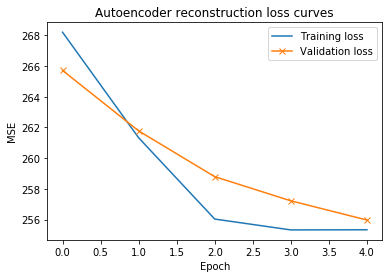

In [48]:
epochs = range(hparams["num_epochs"])
plt.title('Autoencoder reconstruction loss curves')
plt.plot(epochs, train_loss_history, label='Training loss')
plt.plot(epochs, val_loss_history, '-x', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend();

Reconstructed image:

In [49]:
def show_image(image):
    plt.subplot(121).set_title('Original image')
    plt.imshow(image, cmap='gray')
    plt.subplot(122).set_title('Reconstructed image')
    plt.imshow(reconstructed[0][0].detach().cpu().numpy(), cmap='gray');

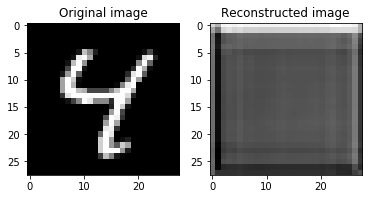

In [51]:
mnist_test = torchvision.datasets.MNIST('mnist_dataset', train=False, transform=transform)
reconstructed = autoencoder(mnist_test[6][0].to(device).unsqueeze(0))
show_image(reconstructed)

Trying with different types of bottlenecks sizes:

In [59]:
bottleneck_sizes = [4, 8, 12, 16, 20]
autoencoders = {}
for bottleneck_size in bottleneck_sizes:
    print("*"*15 + f"Autoencoder bottleneck size {bottleneck_size}" + "*"*15)
    autoencoder = ConvolutionalAutoencoder(2, 'max-pooling', 'nearest', bottleneck_size=bottleneck_size).to(device)
    autoencoders[f"bottleneck_{bottleneck_size}"] = (train(autoencoder, train_dataloader, val_dataloader, mse, adam, hparams["num_epochs"]))
    

***************Autoencoder bottleneck size 4***************
Starting epoch number 1
[Epoch 1, Batch 1] TRAIN loss: 754.279
[Epoch 1, Batch 501] TRAIN loss: 795.454
[Epoch 1, Batch 1001] TRAIN loss: 811.119
[Epoch 1, Batch 1501] TRAIN loss: 802.000
[Epoch 1] VALIDATION loss: 796.526
Starting epoch number 2
[Epoch 2, Batch 1] TRAIN loss: 719.090
[Epoch 2, Batch 501] TRAIN loss: 798.181
[Epoch 2, Batch 1001] TRAIN loss: 813.706
[Epoch 2, Batch 1501] TRAIN loss: 798.601
[Epoch 2] VALIDATION loss: 796.526
Starting epoch number 3
[Epoch 3, Batch 1] TRAIN loss: 868.788
[Epoch 3, Batch 501] TRAIN loss: 803.615
[Epoch 3, Batch 1001] TRAIN loss: 778.830
[Epoch 3, Batch 1501] TRAIN loss: 819.112
[Epoch 3] VALIDATION loss: 796.526
Starting epoch number 4
[Epoch 4, Batch 1] TRAIN loss: 812.685
[Epoch 4, Batch 501] TRAIN loss: 795.353
[Epoch 4, Batch 1001] TRAIN loss: 793.992
[Epoch 4, Batch 1501] TRAIN loss: 797.278
[Epoch 4] VALIDATION loss: 796.526
Starting epoch number 5
[Epoch 5, Batch 1] TRAIN

[Epoch 2, Batch 501] TRAIN loss: 792.770
[Epoch 2, Batch 1001] TRAIN loss: 784.937
[Epoch 2, Batch 1501] TRAIN loss: 780.204
[Epoch 2] VALIDATION loss: 782.317
Starting epoch number 3
[Epoch 3, Batch 1] TRAIN loss: 791.926
[Epoch 3, Batch 501] TRAIN loss: 780.427
[Epoch 3, Batch 1001] TRAIN loss: 784.379
[Epoch 3, Batch 1501] TRAIN loss: 800.127
[Epoch 3] VALIDATION loss: 782.317
Starting epoch number 4
[Epoch 4, Batch 1] TRAIN loss: 885.269
[Epoch 4, Batch 501] TRAIN loss: 790.982
[Epoch 4, Batch 1001] TRAIN loss: 794.081
[Epoch 4, Batch 1501] TRAIN loss: 778.313
[Epoch 4] VALIDATION loss: 782.317
Starting epoch number 5
[Epoch 5, Batch 1] TRAIN loss: 767.891
[Epoch 5, Batch 501] TRAIN loss: 798.200
[Epoch 5, Batch 1001] TRAIN loss: 795.288
[Epoch 5, Batch 1501] TRAIN loss: 788.522
[Epoch 5] VALIDATION loss: 782.317
Starting epoch number 6
[Epoch 6, Batch 1] TRAIN loss: 800.296
[Epoch 6, Batch 501] TRAIN loss: 771.698
[Epoch 6, Batch 1001] TRAIN loss: 771.569
[Epoch 6, Batch 1501] TRA

[Epoch 3] VALIDATION loss: 780.986
Starting epoch number 4
[Epoch 4, Batch 1] TRAIN loss: 792.963
[Epoch 4, Batch 501] TRAIN loss: 773.356
[Epoch 4, Batch 1001] TRAIN loss: 791.957
[Epoch 4, Batch 1501] TRAIN loss: 802.477
[Epoch 4] VALIDATION loss: 780.986
Starting epoch number 5
[Epoch 5, Batch 1] TRAIN loss: 736.825
[Epoch 5, Batch 501] TRAIN loss: 774.838
[Epoch 5, Batch 1001] TRAIN loss: 808.184
[Epoch 5, Batch 1501] TRAIN loss: 789.004
[Epoch 5] VALIDATION loss: 780.986
Starting epoch number 6
[Epoch 6, Batch 1] TRAIN loss: 771.235
[Epoch 6, Batch 501] TRAIN loss: 791.851
[Epoch 6, Batch 1001] TRAIN loss: 797.599
[Epoch 6, Batch 1501] TRAIN loss: 791.285
[Epoch 6] VALIDATION loss: 780.986
Starting epoch number 7
[Epoch 7, Batch 1] TRAIN loss: 801.068
[Epoch 7, Batch 501] TRAIN loss: 786.874
[Epoch 7, Batch 1001] TRAIN loss: 783.410
[Epoch 7, Batch 1501] TRAIN loss: 788.397
[Epoch 7] VALIDATION loss: 780.986
Starting epoch number 8
[Epoch 8, Batch 1] TRAIN loss: 887.122
[Epoch 8, 

In [60]:
autoencoders

{'bottleneck_4': ([796.8727264648315,
   814.0396957022018,
   779.0366403705914,
   804.0274413400041,
   786.5703865167659,
   783.4169831921909,
   820.8561410190322,
   784.8186301498921,
   825.9333383242777,
   802.3549787746408,
   799.1122753258854,
   816.086036415483,
   794.516998678388,
   837.5767215623489,
   811.5647133097755],
  [796.5256217447917,
   796.52562109375,
   796.5256197916667,
   796.5256243489583,
   796.525619140625,
   796.5256197916667,
   796.5256223958334,
   796.52562109375,
   796.5256236979167,
   796.5256217447917,
   796.5256204427084,
   796.5256204427084,
   796.5256217447917,
   796.5256204427084,
   796.5256197916667]),
 'bottleneck_8': ([790.5913308023371,
   782.9490515439447,
   793.4677693032294,
   786.0014556219419,
   784.118671680519,
   774.7391167319926,
   768.5633435638404,
   790.0554776257175,
   784.0662199501137,
   773.0420164625102,
   783.9684136718778,
   785.1133982094357,
   788.6871157551928,
   798.4609362912762,
   76